# One-way ANOVA

Imagine you have three groups, and you want to do a one-level ANOVA to test for
overall differences across the groups.

The general technique for a permutation test is:

* You decide on your metric
* You get your metric for the actual data - observed metric
* You permute your data and take the same metric from the permuted data, and
  repeat many times - fake metrics
* You compare your observed metric to your fake metrics, to see how unusual it
  is.

For a two-sample permutation test, your metric is the difference in the two
sample means.

For a three sample version of the test — we need a metric that will be big
where there are big differences between the three groups, and small when there
are small differences.

Let us reflect on what what we want from the metric.  It should be a single
number to summarize all the values from the groups. It should be be large for
big differences between the means for the various groups.  It should be larger
when more observations are in the groups with large difference in means.

Consider the following metric.  We will soon see this is the metric that the F-test uses.

* Get the sample means for each of the three groups A, B, C, to give `mean_a`,
  `mean_b`, `mean_c`
* Get the mean across all the observations regardless of group
  (`mean_overall`)
* Subtract `mean_overall` from each of `mean_a`, `mean_b`, `mean_c` to give
  `mean_a_diff`, `mean_b_diff`, `mean_c_diff`.
* We are interested in positive as well as negative differences, so we do not
  want to add these mean differences, otherwise the positive and negative means
  differences will cancel out. So we next square the differences to give:
  `sq_mean_a_diff`, `sq_mean_b_diff`, `sq_mean_c_diff`.
* We want larger groups to have greater weight than small groups.  Call the
  number in groups A, B, and C `n_a`, `n_b`, `n_c`. To weight the squared mean
  differences we multiply each square mean difference by the number in each
  group: `sq_mean_a_diff * n_a`, `sq_mean_b_diff * n_b`, `sq_mean_c_diff *
  n_c`, to give `nsq_mean_a_diff`, `nsq_mean_b_diff`, `nsq_mean_c_diff`.
*   Finally, we add up the group `nsq` scores to give our metric:

    ```
    our_metric = nsq_mean_a_diff + nsq_mean_b_diff + nsq_mean_c_diff
    ```

We will call this the SNSQGMD metric (Sum of N times SQuared Group Mean
Difference).

SNSQGMD will be large and positive when the individual groups have different
means from each other and small when the means for the groups are pretty
similar to each other, and therefore, to the overall mean.  It will be larger
when larger groups have means with bigger deviations from the overall mean.

To follow the recipe above, we calculate SNSQGMD for the actual groups A, B, C.
Permute the group labels to give random groups A, B, C, and recalculate the
metric.   See whether SNSQGMD in the real data is unusual in the distribution of
the same metric for the permuted groups.

This is the permutation equivalent of the one-way ANOVA.   The one-way ANOVA
just uses some assumptions from the normal distribution to estimate the spread
in the random distribution of SNSQGMD, instead of using permutation to calculate
the random distribution.


## An example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Our dataset is a table giving the amount of weight lost for a group of people allocated to one of three possible diets, called `A`, `B` and `C`.

See: [the dataset page](https://github.com/odsti/datasets/tree/master/sheffield_diet) for more detail.

In [2]:
# Read the raw dataset
diet_data = pd.read_csv('sheffield_diet.csv')
diet_data.head()

,gender,diet,weight_lost
0,Female,A,3.8
1,Female,A,6.0
2,Female,A,0.7
3,Female,A,2.9
4,Female,A,2.8


Here we are only interested in the last two columns:

In [3]:
diets = diet_data.loc[:, ['diet', 'weight_lost']]
diets.head()

,diet,weight_lost
0,A,3.8
1,A,6.0
2,A,0.7
3,A,2.9
4,A,2.8


Each row corresponds to one person. The `diet` column names the diet to which
that person was allocated.  The `weight_lost` column has the number of
kilograms weight lost by that person after 10 weeks of following the diet.

We are interested to know if the diets `A`, `B` and `C` differ overall in the
amount of weight loss for people on that diet.

We call the allocated diet the *group* to which the person
(row) belongs.


## Means by group

Here are the data, plotted by group.

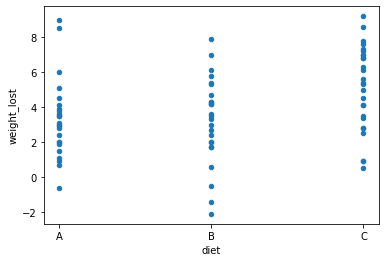

In [4]:
diets.plot.scatter('diet', 'weight_lost');

These are the means for each of the three groups.

In [5]:
group_means = diets.groupby('diet').mean()
group_means

,weight_lost
diet,
A,3.300000
B,3.268000
C,5.148148


Here is the overall mean, ignoring the group membership:

In [6]:
overall_mean = np.mean(diets['weight_lost'])
overall_mean

3.9460526315789486

The next collection of cells shows the data, the group means, and the overall mean:

In [7]:
# Function to show the group and overall mean
def plot_mean_diffs(df, group_col, val_col):
    # Get the overall mean
    mean_all = np.mean(df[val_col])
    # Get the means by group.
    means_grp = df.groupby(group_col)[val_col].mean()
    # Group names
    grp_names = df[group_col].unique()
    n_groups = len(grp_names)
    # Plot red dots at group means.
    plt.scatter(grp_names, means_grp, color='red', label='Group means')
    # Plot green dashed line at the overall mean.
    plt.plot(grp_names, np.repeat(mean_all, n_groups),
             ':', color='green', label='Overall mean')
    # A red dashed line between each group mean and the overall mean.
    for grp_name in grp_names:
        xs = [grp_name, grp_name]
        ys = [mean_all, float(means_grp.loc[grp_name])]
        plt.plot(xs, ys, ':', color='red')
    plt.legend();

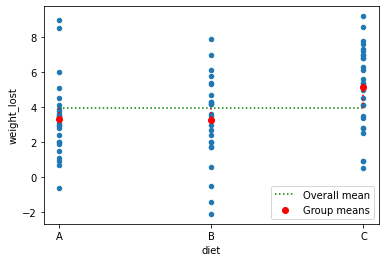

In [8]:
# Show all the data values by diet.
diets.plot.scatter('diet', 'weight_lost')
# Show the group means and overall mean.
plot_mean_diffs(diets, 'diet', 'weight_lost')

Notice the red dashed lines between the group means and the
overall mean.  To make these easier to see, here is the same
plot, without the individual data points:

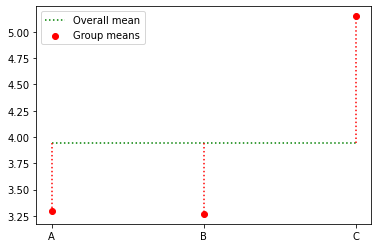

In [9]:
plot_mean_diffs(diets, 'diet', 'weight_lost')

## Removing the overall mean

The first step in analysis is to subtract the overall mean from the data.  We do this because we are interested in the *difference* of the diet (group) means from the overall mean.

Put another way, we accept that diets, overall, will lead to some level of weight lost; our question is whether this level *differs* between the diets.

By removing the overall mean, we remove the average effect of the three diets, allowing us to concentrate on the difference in effect.

In [10]:
# "zm" stands for "zero mean"
diets_zm = pd.DataFrame()
diets_zm['diet'] = diets['diet'].copy()
diets_zm['wlost_zm'] = diets['weight_lost'] - overall_mean
diets_zm.head()

,diet,wlost_zm
0,A,-0.146053
1,A,2.053947
2,A,-3.246053
3,A,-1.046053
4,A,-1.146053


As usual, when we subtract the mean from a column, the mean of the result is zero.  Actually, because of very small calculation error, it is very close to zero.

In [11]:
np.mean(diets_zm['wlost_zm'])

-1.3264243504732134e-15

If we calculate the new group means for the ZM data, they are the same as the original group means, minus the overall mean:

In [12]:
gmeans_zm = diets_zm.groupby('diet').mean()
gmeans_zm

,wlost_zm
diet,
A,-0.646053
B,-0.678053
C,1.202096


Here is the plot of the group means, now centered around zero:

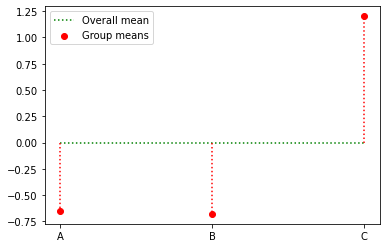

In [13]:
plot_mean_diffs(diets_zm, 'diet', 'wlost_zm')

## The SNSQGMD metric

We designed our SNSQGMD metric to be large when the sum of the squared lengths of
these lines are large.  The N in  SNSQGMD reminds us we multiply each squared
length by the number in the group, to give more weight to large groups.

To calculate SNSQGMD we get the Group Mean Difference.

Because we have already subtracted the overall mean, the group means of the ZM values are the group mean differences.

In [14]:
gmd = gmeans_zm  # Remember, the overall mean here is already (near) 0
gmd

,wlost_zm
diet,
A,-0.646053
B,-0.678053
C,1.202096


We square these differences:

In [15]:
sq_gmd = gmd ** 2
sq_gmd

,wlost_zm
diet,
A,0.417384
B,0.459755
C,1.445034


We want to give more weight to groups with more members, so we multiply each
squared difference by the number in the group:

In [16]:
# Numbers in each group
group_ns = diets_zm.groupby('diet').count()
group_ns

,wlost_zm
diet,
A,24
B,25
C,27


In [17]:
n_sq_gmd = sq_gmd * group_ns
n_sq_gmd

,wlost_zm
diet,
A,10.017216
B,11.493884
C,39.015908


Finally, we add up these weighted squares to get the final metric:

In [18]:
observed_sn_sq_gmd = np.sum(n_sq_gmd)
observed_sn_sq_gmd

wlost_zm    60.527008
dtype: float64

To make the process a bit clearer, here is the same calculation in its own function so we can re-use it on different data frames.

In [19]:
def get_sn_sq_gmd(df, group_col, val_col):
    grouped = df.groupby(group_col)[val_col]
    sq_gmd = grouped.mean() ** 2
    return np.sum(sq_gmd * grouped.count())

Check that we get the same answer from the function as we did with the
step-by-step calculation:

In [20]:
get_sn_sq_gmd(diets_zm, 'diet', 'wlost_zm')

60.527008382066285

Next we consider a single trial in our ideal, null, fake world.  We do this by
making a copy of the data frame, and then permuting the diet labels, so
the association between the diet and the change values is random.

In [21]:
fake_data = diets_zm.copy()
# Permute the group labels
fake_data['diet'] = np.random.permutation(fake_data['diet'])
fake_data.head()

,diet,wlost_zm
0,C,-0.146053
1,C,2.053947
2,A,-3.246053
3,C,-1.046053
4,A,-1.146053


We calculate our metric on these new data, step by step.

In [22]:
fake_grouped = fake_data.groupby('diet')['wlost_zm']
# Notice that the overall mean of 0 cannot change because we did not
# change the values that make up the mean.
fake_sq_gmd = fake_grouped.mean() ** 2
fake_sn_sq_gmd = np.sum(fake_sq_gmd * fake_grouped.count())
fake_sn_sq_gmd

24.35048245614034

We can also use the function above to do that calculation, and get the same
answer:

In [23]:
get_sn_sq_gmd(fake_data, 'diet', 'wlost_zm')

24.35048245614034

Now we are ready to do our simulation.  We do 10000 trials. In each trial, we
make a new random association, and recalculate the sum of squares metric.

In [24]:
n_iters = 10000
fake_sn_sq_gmds = np.zeros(n_iters)
for i in np.arange(n_iters):
    # Make sample from null world.
    fake_data['diet'] = np.random.permutation(fake_data['diet'])
    # Calculate corresponding metric.
    fake_sn_sq_gmds[i] = get_sn_sq_gmd(fake_data, 'diet', 'wlost_zm')

Of course, because these are sums of squares, they must all be positive.

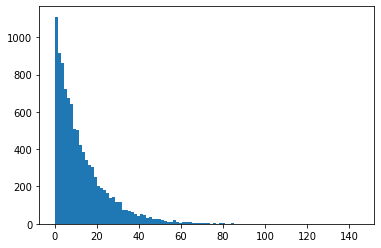

In [25]:
plt.hist(fake_sn_sq_gmds, bins=100);

How does our observed sum of squares metric compare to the distribution of fake
sum of square metrics?

In [26]:
p = np.count_nonzero(fake_sn_sq_gmds >= float(observed_sn_sq_gmd)) / n_iters
p

0.0072

The p value tells us that this observed metric is very unlikely to have come
about in a random world.


## Comparing to standard one-way ANOVA F tests

In this section, we do the standard F-test calculations to show that we get a
similar p value to the permutation version above.  This is the Statsmodels
implementation of the one-way F test:

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols('weight_lost ~ diet', data=diets).fit()

sm.stats.anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
diet,2.0,60.527008,30.263504,5.383104,0.006596
Residual,73.0,410.401807,5.621943,NaN,NaN


Notice that the SNSQGMD metric value appears in the `diet` row, `sum_sq` column.

Here is the same calculation in Scipy:

In [28]:
from scipy.stats import f_oneway

In [29]:
# Get the values from the individual groups.
treatment = diets['diet']
change = diets['weight_lost']
# Subtract the overall mean
# (Actually, that doesn't change the calculation of the F test below,
# but, just for completeness).
change_zm = change - np.mean(change)
# Get the values in the individual groups.
diet_a_values = np.array(change_zm[treatment == 'A'])
diet_b_values = np.array(change_zm[treatment == 'B'])
diet_c_values = np.array(change_zm[treatment == 'C'])

Do the F-test:

In [30]:
f_result = f_oneway(diet_a_values, diet_b_values, diet_c_values)
f_result

F_onewayResult(statistic=5.383104474859932, pvalue=0.0065958531086696805)

Notice Scipy gives the same F statistic value and p value as Statsmodels.

## The F statistic and the SNSQGMD metric

In this section, we go into more detail about the calculation of the F value
that you see above.  Here is the F statistic we got from Scipy (and
Statsmodels):

In [31]:
F_stat = f_result.statistic
F_stat

5.383104474859932

This section goes through the calculation of the F statistic from the SNSQGMD
metric.  This is the SNSQGMD value we calculated:

In [32]:
observed_sn_sq_gmd

wlost_zm    60.527008
dtype: float64

You can get the F statistic above by dividing the SNSQGMD metric by a scaled
estimate of the variation still present in the data.

The variation still present in the data are the remaining distances between the
data (in the plot above) and their corresponding group means.  Call these
remaining distances the "residuals".

Subtract each group mean from their respective group values:

In [33]:
# Calculate the residuals from the group means.
diet_a_resid = diet_a_values - np.mean(diet_a_values)
diet_b_resid = diet_b_values - np.mean(diet_b_values)
diet_c_resid = diet_c_values - np.mean(diet_c_values)

Finally, we sum up the squares of these residuals:

In [34]:
# We concatenate the three sets of residuals into one long array.
all_group_resid = np.concatenate(
    [diet_a_resid, diet_b_resid, diet_c_resid])
# Sum of squared residuals from group means.
ssq_resid_groups = np.sum(all_group_resid ** 2)
ssq_resid_groups

410.40180740740743

You will see this value in the `Residual` row, `sum_sq` column of the Statsmodels output above.

The F-statistic results from dividing this measure of remaining variation into
the SNSQGMD metric, with some scaling.  The scaling comes from the number of
observations, and the number of groups.

In [35]:
n_obs = len(diets)
n_groups = len(group_means)

Here is the full calculation of the F-statistic. Notice that it is exactly the
same as we got from Scipy and Statsmodels.

In [36]:
# Calculate of the F value by scaling and dividing by residual variation
# metric.
df_groups = n_groups - 1  # Degrees of freedom for groups.
df_error = n_obs - n_groups  # Degrees of freedom for residuals.
# The F statistic
(observed_sn_sq_gmd / df_groups) / (ssq_resid_groups / df_error)

wlost_zm    5.383104
dtype: float64

Scaling and dividing by the residual variation gives a value that we can reason
about with some standard mathematics, as long as we are prepared to assume that
the values come from a normal distribution.  Specifically, with those
assumptions, we can get a p value by comparing the observed F value to a
standard F distribution with the same "degrees of freedom".  These are the
`df_groups` and `df_error` values above.

In [37]:
# Get standard F distribution object from Scipy.
from scipy.stats import f as f_dist

# Look up p value for a particular F statistic and degrees of freedom.
# Notice the p value is the same as the p value from Scipy f_oneway
# and from Statsmodels.
f_dist(df_groups, df_error).sf(F_stat)

0.0065958531086696805

As you have seen, the permutation estimate gives a very similar answer.  We
would argue that it is also a lot easier to explain.

## F tests in terms of explained variation

You will often see explanations of the F-value in terms of the amount of
variation explained by the overall mean, compared to the amount of variation
explained with the individual group means.  In fact, this "variance" way of
thinking is what gave the test the name ANOVA (Analysis of Variance).

The explained variation path (literally) adds up to the same thing as the
SNSQGMD metric version of the F statistic above.  The current section goes
through the explained variation way of thinking of the F statistic, and shows
that it gives the same value for the SNSQGMD metric.

The "variance" way of thinking about the F looks at the sum of squared
"residual" variation in two situations.  First we look at the residual variation
after we subtract the group means.  We already have this from the F test
calculation above.  Here we repeat the calculation as a reminder of what the
value means:

In [38]:
ssq_resid_groups = np.sum(all_group_resid ** 2)
ssq_resid_groups

410.40180740740743

This is the sum of squared remaining variation when using the group means.

We compare this to the squared remaining variation when after subtracting the *overall mean*.  Here is that calculation.

In [39]:
# Sum of squared residuals using overall mean.
# Remember, we did this calculation above.
# Square and sum the residuals to get the squared variation from overall mean.
ssq_resid_overall = np.sum(diets_zm['wlost_zm'] ** 2)
ssq_resid_overall

470.9288157894737

The variance way of thinking says that we should be particularly interested in
our group means, when using them does a very good job of reducing the
variation.  This will happen when the group values are a lot closer to their
individual group means, than they are to the overall mean.  In that case,
`ssq_resid_groups` will be much lower than `ssq_resid_overall`, so we will get
a fairly high value for `ssq_resid_overall - ssq_resid_groups`.  The result of
this subtraction is called the *extra sum of squares* explained by the sample
means:

In [40]:
ess = ssq_resid_overall - ssq_resid_groups
ess

60.52700838206624

Remember, `ssq_resid_overall` is the (sum of squared) variation remaining after
accounting for the overall mean, and `ssq_resid_groups` is the (sum of squared)
variation remaining after accounting for the sample means, so `ess` is the
*extra* variation accounted for by using the sample means.

But — wait — the `ess` value is *exactly* the same as the SNSQGMD metric we
were already using!

In [41]:
observed_sn_sq_gmd

wlost_zm    60.527008
dtype: float64

This striking fact is true for any possible values and groups, and arises from
the algebra of adding squared deviations from means.  The equivalence gives us
two different ways of thinking of the same SNSQGMD metric value.  The SNSQGMD
value is both:

* A measure of how far the sample means are from the overall mean, AND
* A measure of how much variation the sample means explain, over and above the
  overall mean.

In this second "explained variance" interpretation, we think of the F test
calculation as being a scaled ratio of the extra variance explained by the
sample means to the variance still remaining when we use the sample means.  If
the sample means explain a lot of variation, then the top half of the F
statistic will be large, and the bottom half will be small, giving a large F
value.